In [7]:
import nltk
#nltk.download('stopwords')
import numpy as np
import pandas as pd
#import spacy
import gensim
import WebScraper
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import warnings
import requests


In [2]:
warnings.warn('hey',category = DeprecationWarning)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: hey
  """Entry point for launching an IPython kernel.


In [3]:
warnings.filterwarnings("ignore",category=DeprecationWarning)

warnings.warn('hey',category=UserWarning)
warnings.warn('hey',category=DeprecationWarning)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: hey
  This is separate from the ipykernel package so we can avoid doing imports until


In [1]:
import WebScraper
import TopicModeling

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tansel.arif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Fitering Deprecation Warnings!


In [2]:
import importlib
importlib.reload(TopicModeling)

Fitering Deprecation Warnings!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tansel.arif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'TopicModeling' from 'C:\\Users\\tansel.arif\\Documents\\Temp\\Topic-Modeling\\Code\\TopicModeling.py'>

### Latent Dirichlet Allocation (LDA)

LDA assumes that each document is composed of a collection of topics with varying probabilities and that each topic is a collection of words with varying probabilities. 

## Get the review data

In [3]:
inurl1 = "https://www.tripadvisor.co.uk/Attraction_Review-g190384-d6755801-Reviews"
inurl2 = "-The_House_of_Dionysus-Paphos_Paphos_District.html"

ms = WebScraper.WebScraper(site='tripadvisor',url1=inurl1,
                      url2=inurl2,increment_string1="-or",increment_string2="",
                      total_pages=2,increment=10,silent=False)

ms.fullscraper()

review_data = ms.all_reviews

Getting reviews 0/ 2


C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Diagnostics: Checking if dataframes are of equal size...
Size: 10
Size: 10
Size: 10
Size: 10
Diagnostics complete!
Getting reviews 1/ 2


C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Diagnostics: Checking if dataframes are of equal size...
Size: 10
Size: 10
Size: 10
Size: 10
Diagnostics complete!
Getting reviews 2/ 2
Complete!!!


In [4]:
myTopicModel = TopicModeling.TopicModeling(review_data)
myTopicModel.ldaFromReviews()
myTopicModel.generate_wordcloud()


 The Coherence Score with 2 topics is 0.279992086632212

 The Coherence Score with 3 topics is 0.27376744899677274

 The Coherence Score with 4 topics is 0.44301947807614145

 The Coherence Score with 5 topics is 0.531933427178539


C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


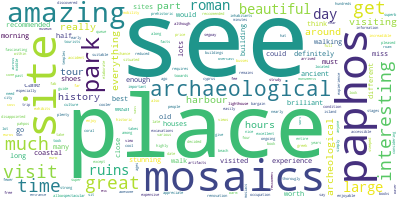

In [6]:
myTopicModel.showWordCloud()

In [13]:
#myTopicModel.ldavis
pyLDAvis.save_html(myTopicModel.ldavis,'LDAOutput2.html')

In [12]:
review_data.head()

,Review,title,Rating,date,fullreview
0,We came across this place by accident while wa...,Great place to visit,5,Reviewed today,We came across this place by accident while wa...
1,An amazing part of The Archaeological Park wit...,Part of The Archaeological Park,5,Reviewed 5 days ago,An amazing part of The Archaeological Park wit...
2,"You can roam free through this park, and get r...",Very interesting,4,Reviewed 5 days ago,"You can roam free through this park, and get r..."
3,Can’t see much from the coastal walk except li...,Amazing place,5,Reviewed 1 week ago,Can’t see much from the coastal walk except li...
4,Don't miss the chance to visit such an histori...,Steeped in facts,4,Reviewed 1 week ago,Don't miss the chance to visit such an histori...


## Get the english stopwords

In [16]:
stopwords = nltk.corpus.stopwords.words('english')

In [17]:
stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

## Clean the reviews

We will use gensim.utils.simple_prepocess to create a list of words for each document.

In [18]:
gensim.utils.simple_preprocess("Where's my dog?",deacc = True)

['where', 'my', 'dog']

deacc=True stands for de-accentise the text. Here's an example from the documentation

In [19]:
gensim.utils.deaccent("Šéf chomutovských komunistů dostal poštou bílý prášek")

'Sef chomutovskych komunistu dostal postou bily prasek'

Let's try this out for a particular review

In [20]:
review_data.iloc[0,0]

NameError: name 'review_data' is not defined

In [18]:
gensim.utils.simple_preprocess(review_data.iloc[0,0],deacc = True)

['an',
 'amazing',
 'part',
 'of',
 'the',
 'archaeological',
 'park',
 'with',
 'the',
 'ruins',
 'from',
 'many',
 'hundreds',
 'of',
 'years',
 'ago',
 'and',
 'mosaics',
 'in',
 'excellent',
 'condition',
 'considering',
 'how',
 'long',
 'they',
 'have',
 'been',
 'there']

We can then remove stopwords from this document (notice the removal of 'this', 'is', 'and' and similar words.)

In [19]:
[word for word in gensim.utils.simple_preprocess(review_data.iloc[0,0],deacc = True) if word not in stopwords]

['amazing',
 'part',
 'archaeological',
 'park',
 'ruins',
 'many',
 'hundreds',
 'years',
 'ago',
 'mosaics',
 'excellent',
 'condition',
 'considering',
 'long']

Create a function to do this

In [20]:
def cleanDocument(x, stopwords):
    return [word for word in gensim.utils.simple_preprocess(x,deacc = True) 
            if word not in stopwords]

In [21]:
cleanDocument(review_data.iloc[0,0],stopwords)

['amazing',
 'part',
 'archaeological',
 'park',
 'ruins',
 'many',
 'hundreds',
 'years',
 'ago',
 'mosaics',
 'excellent',
 'condition',
 'considering',
 'long']

OK, so far so good. Create a new column for the list representation of the document for each document

In [22]:
review_data['List'] = review_data['fullreview'].apply(lambda x: cleanDocument(x,stopwords))

In [23]:
review_data.head()

,Review,title,Rating,date,fullreview,List
0,An amazing part of The Archaeological Park wit...,Part of The Archaeological Park,5,Reviewed 5 days ago,An amazing part of The Archaeological Park wit...,"[amazing, part, archaeological, park, ruins, m..."
1,"You can roam free through this park, and get r...",Very interesting,4,Reviewed 5 days ago,"You can roam free through this park, and get r...","[roam, free, park, get, really, close, artifac..."
2,Can’t see much from the coastal walk except li...,Amazing place,5,Reviewed 1 week ago,Can’t see much from the coastal walk except li...,"[see, much, coastal, walk, except, lighthouse,..."
3,Don't miss the chance to visit such an histori...,Steeped in facts,4,Reviewed 1 week ago,Don't miss the chance to visit such an histori...,"[miss, chance, visit, historic, site, lots, in..."
4,A great look at the mosaics of Roman inhabitan...,Archeological Expierience,5,Reviewed 1 week ago,A great look at the mosaics of Roman inhabitan...,"[great, look, mosaics, roman, inhabitants, pap..."


Create Bigrams and Trigrams and more. Bigrams are pairs of words that occur together often. Similarly, Trigrams a 3 words frequently occuring together. This can be extended to a larger number of words occuring together.

In [24]:
# Create bigrams
bigrams = gensim.models.Phrases(review_data['List'], min_count=3, threshold=50)
bigrams_Phrases= gensim.models.phrases.Phraser(bigrams)

# Create trigrams
trigrams = gensim.models.Phrases(bigrams_Phrases[list(review_data['List'])], min_count=3, threshold=50) 
trigram_Phrases = gensim.models.phrases.Phraser(trigrams)

In [25]:
print(bigrams_Phrases[review_data['List'][0]])

['amazing', 'part', 'archaeological', 'park', 'ruins', 'many', 'hundreds', 'years', 'ago', 'mosaics', 'excellent', 'condition', 'considering', 'long', 'part', 'archaeological', 'park']


Here, we don't see any bigrams but the idea is shown below with an example

In [26]:
a = []

a.append('new york is amazing')
a.append("Yeah I know, it's all about new york")
a.append("What about the tower in new york?")
a.append("new york is the place to be apparently")
a.append("Some more words and new york some more words")
a.append("I loved the show")
a.append("specially in new york")

a_list = list(map(lambda x: cleanDocument(x,stopwords),a))
bigram = gensim.models.Phrases(a_list,min_count=1, threshold=1)
bigram_phraser = gensim.models.phrases.Phraser(bigram)
sent = cleanDocument('Is new york the best place or what?',stopwords)
print(bigram_phraser[sent])

['new_york', 'best', 'place']


So, new york is classed as a bigram. The min_count argument specifies the minimum number of times this bigram should appear before it is accepted as a bigram. The threshold determines how difficult it is to be classified as a bigram.

Let's create a function for this.

In [27]:
def createGrams(ls):
    """
    This function expects a list (or series) of lists of words each being a list representation of a document.
    It returns a list of bigrams and a list of Trigrams relevant to the list given.
    """
    # Create bigrams
    bigrams = gensim.models.Phrases(ls, min_count=3, threshold=50)
    bigrams_Phrases= gensim.models.phrases.Phraser(bigrams)

    # Create trigrams
    trigrams = gensim.models.Phrases(bigrams_Phrases[list(ls)], min_count=3, threshold=50) 
    trigram_Phrases = gensim.models.phrases.Phraser(trigrams)
    
    return [bigrams_Phrases[i] for i in list(ls)],[trigram_Phrases[i] for i in list(ls)]

In [28]:
createGrams(review_data['List'])

([['amazing',
   'part',
   'archaeological',
   'park',
   'ruins',
   'many',
   'hundreds',
   'years',
   'ago',
   'mosaics',
   'excellent',
   'condition',
   'considering',
   'long',
   'part',
   'archaeological',
   'park'],
  ['roam',
   'free',
   'park',
   'get',
   'really',
   'close',
   'artifacts',
   'ruins',
   'ancient',
   'buildings',
   'mosaics',
   'fascinating',
   'visited',
   'segway',
   'tour',
   'paphos',
   'brilliant',
   'highly',
   'recommended',
   'entrance',
   'fee',
   'euros',
   'interesting'],
  ['see',
   'much',
   'coastal',
   'walk',
   'except',
   'lighthouse',
   'think',
   'would',
   'much',
   'see',
   'day',
   'overcast',
   'decided',
   'go',
   'warm',
   'enough',
   'sit',
   'sun',
   'disappointed',
   'get',
   'half_price',
   'think',
   'amazing',
   'place'],
  ['miss',
   'chance',
   'visit',
   'historic',
   'site',
   'lots',
   'interesting',
   'information',
   'culture',
   'definitely',
   'go',
   'v

Now we can utilise the cleanDocument function to write a new function to give us directly the list representation of a document while considering bigrams and trigrams

In [29]:
def cleanAndCreateGrams(ls,stopwords):
    return(createGrams(ls.apply(lambda x: cleanDocument(x,stopwords)))[0])

In [30]:
review_data['GramList'] = cleanAndCreateGrams(review_data['fullreview'],stopwords)

review_data.head()

,Review,title,Rating,date,fullreview,List,GramList
0,An amazing part of The Archaeological Park wit...,Part of The Archaeological Park,5,Reviewed 5 days ago,An amazing part of The Archaeological Park wit...,"[amazing, part, archaeological, park, ruins, m...","[amazing, part, archaeological, park, ruins, m..."
1,"You can roam free through this park, and get r...",Very interesting,4,Reviewed 5 days ago,"You can roam free through this park, and get r...","[roam, free, park, get, really, close, artifac...","[roam, free, park, get, really, close, artifac..."
2,Can’t see much from the coastal walk except li...,Amazing place,5,Reviewed 1 week ago,Can’t see much from the coastal walk except li...,"[see, much, coastal, walk, except, lighthouse,...","[see, much, coastal, walk, except, lighthouse,..."
3,Don't miss the chance to visit such an histori...,Steeped in facts,4,Reviewed 1 week ago,Don't miss the chance to visit such an histori...,"[miss, chance, visit, historic, site, lots, in...","[miss, chance, visit, historic, site, lots, in..."
4,A great look at the mosaics of Roman inhabitan...,Archeological Expierience,5,Reviewed 1 week ago,A great look at the mosaics of Roman inhabitan...,"[great, look, mosaics, roman, inhabitants, pap...","[great, look, mosaics, roman, inhabitants, pap..."


In [31]:
# en_spacy = spacy.load('en')

# doc = en_spacy(" ".join(review_data['GramList'][0]))

# print(doc[2].pos_)

The LDA model we will be using as part of the gensim package expects a corpus list and an id2word dictionary. To create the id2word dictionary, we use the gensim.corpora.Dictionary method which takes a list of documents in list representation (our 'GramList' column we created above) and gives a dictionary. To create a corpus where a word has the same id over all the documents we can use the id2word.doc2bow which does what we're looking for.

In [32]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(review_data['GramList'])

# Create Corpus
texts = review_data['GramList']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

id2word is a disctionary. We can get the frequency of each word in id2word by using its index representation

In [33]:
id2word[1]

'amazing'

In [34]:
print(f"The frequency of '{id2word[1]}' is {corpus[0][1][1]}")

The frequency of 'amazing' is 1


And here is an entire document in id, frequency representation

In [35]:
texts[100]

['hot',
 'enjoyable',
 'archaeological',
 'experience',
 'mosaics',
 'amazing',
 'interested',
 'historical',
 'sites',
 'worth',
 'visiting',
 'great',
 'experience']

In [36]:
id2word.doc2bow(texts[100])

[(1, 1),
 (2, 1),
 (9, 1),
 (67, 1),
 (110, 1),
 (126, 1),
 (127, 2),
 (143, 1),
 (147, 1),
 (246, 1),
 (455, 1),
 (518, 1)]

In [37]:
# from id to word
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('ago', 1),
  ('amazing', 1),
  ('archaeological', 2),
  ('condition', 1),
  ('considering', 1),
  ('excellent', 1),
  ('hundreds', 1),
  ('long', 1),
  ('many', 1),
  ('mosaics', 1),
  ('park', 2),
  ('part', 2),
  ('ruins', 1),
  ('years', 1)],
 [('mosaics', 1),
  ('park', 1),
  ('ruins', 1),
  ('ancient', 1),
  ('artifacts', 1),
  ('brilliant', 1),
  ('buildings', 1),
  ('close', 1),
  ('entrance', 1),
  ('euros', 1),
  ('fascinating', 1),
  ('fee', 1),
  ('free', 1),
  ('get', 1),
  ('highly', 1),
  ('interesting', 1),
  ('paphos', 1),
  ('really', 1),
  ('recommended', 1),
  ('roam', 1),
  ('segway', 1),
  ('tour', 1),
  ('visited', 1)]]

Now we run the LDA model from gensim

In [38]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           alpha='auto',
                                           per_word_topics=True)

In [39]:
myTopicModel.ldamodel.print_topics()

[(0,
  '0.023*"mosaics" + 0.017*"around" + 0.017*"park" + 0.015*"ruins" + 0.011*"roman" + 0.010*"see" + 0.009*"history" + 0.009*"plenty" + 0.009*"lovely" + 0.009*"interesting"'),
 (1,
  '0.043*"mosaics" + 0.032*"visit" + 0.028*"site" + 0.022*"see" + 0.017*"place" + 0.015*"must" + 0.015*"park" + 0.015*"amazing" + 0.015*"paphos" + 0.014*"worth"'),
 (2,
  '0.024*"worth" + 0.020*"site" + 0.018*"well" + 0.016*"interesting" + 0.016*"visit" + 0.011*"mosaics" + 0.011*"get" + 0.010*"excellent" + 0.010*"park" + 0.009*"visited"'),
 (3,
  '0.023*"history" + 0.013*"walking" + 0.012*"area" + 0.012*"like" + 0.011*"see" + 0.011*"much" + 0.010*"quite" + 0.009*"place" + 0.008*"within" + 0.008*"sun"')]

Here is the contribution of each word for each of the 4 topics

In [40]:
# Print the Keyword in the 4 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.023*"mosaics" + 0.017*"around" + 0.017*"park" + 0.015*"ruins" + 0.011*"see" + 0.011*"place" + 0.010*"history" + 0.008*"lots" + 0.008*"roman" + 0.008*"amazing"'), (1, '0.043*"mosaics" + 0.030*"visit" + 0.024*"site" + 0.022*"see" + 0.015*"park" + 0.015*"worth" + 0.014*"must" + 0.013*"paphos" + 0.013*"interesting" + 0.013*"well"'), (2, '0.023*"worth" + 0.021*"site" + 0.018*"well" + 0.017*"interesting" + 0.014*"visit" + 0.013*"mosaics" + 0.011*"get" + 0.010*"excellent" + 0.010*"park" + 0.009*"see"'), (3, '0.023*"history" + 0.016*"area" + 0.016*"place" + 0.013*"visit" + 0.013*"see" + 0.010*"mosaics" + 0.010*"like" + 0.010*"much" + 0.009*"day" + 0.009*"amazing"')]


We can use the coherence score to determine the best number of topics

In [41]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=review_data['GramList'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.731491577575552

Coherence Score:  0.24501165154965557


In [43]:
max_coherence_score = 0
best_n_topics = -1
best_model = None
for i in range(2,6): 
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=i, 
                                               chunksize=100,
                                               alpha='auto',
                                               per_word_topics=True)
    # Compute Coherence Score
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=review_data['GramList'], dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    if max_coherence_score < coherence_lda:
        max_coherence_score = coherence_lda
        best_n_topics = i
        best_model = lda_model
        
    print('\n The Coherence Score with {} topics is {}'.format(i,coherence_lda))


 The Coherence Score with 2 topics is 0.2043063367970835


KeyboardInterrupt: 

Let's see a visualisation per topic

In [44]:
# Visualize the topics
#pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.027172  0.0       1        1  56.505402
1     -0.027172  0.0       2        1  43.494598, topic_info=     Category       Freq            Term       Total  loglift  logprob
term                                                                  
94    Default  13.000000           water   13.000000  30.0000  30.0000
93    Default  16.000000            take   16.000000  29.0000  29.0000
27    Default  32.000000          paphos   32.000000  28.0000  28.0000
45    Default  40.000000           place   40.000000  27.0000  27.0000
88    Default   5.000000             hat    5.000000  26.0000  26.0000
11    Default  14.000000            part   14.000000  25.0000  25.0000
12    Default  22.000000           ruins   22.000000  24.0000  24.0000
155   Default  41.000000         history   41.000000  23.0000  23.0000
46    Default  58.000000             see   58.000000  22.0000  22.0000
286   Default  10.000000          lovely   10.000000  21.0000  21.0000
275   Default  10.000000       fantastic   10.000000  20.0000  20.0000
5     Default  17.000000       excellent   17.000000  19.0000  19.0000
90    Default   7.000000          plenty    7.000000  18.0000  18.0000
229   Default  17.000000         walking   17.000000  17.0000  17.0000
70    Default  14.000000           large   14.000000  16.0000  16.0000
96    Default   7.000000           along    7.000000  15.0000  15.0000
110   Default   9.000000        visiting    9.000000  14.0000  14.0000
156   Default   6.000000          houses    6.000000  13.0000  13.0000
258   Default   7.000000           loved    7.000000  12.0000  12.0000
147   Default  45.000000           worth   45.000000  11.0000  11.0000
242   Default   3.000000         degrees    3.000000  10.0000  10.0000
256   Default  27.000000            good   27.000000   9.0000   9.0000
925   Default   6.000000            real    6.000000   8.0000   8.0000
302   Default   7.000000           value    7.000000   7.0000   7.0000
172   Default  13.000000         harbour   13.000000   6.0000   6.0000
554   Default   5.000000            huge    5.000000   5.0000   5.0000
87    Default   4.000000      everything    4.000000   4.0000   4.0000
488   Default   3.000000           lucky    3.000000   3.0000   3.0000
707   Default   4.000000       make_sure    4.000000   2.0000   2.0000
247   Default  10.000000            like   10.000000   1.0000   1.0000
...       ...        ...             ...         ...      ...      ...
12     Topic2  14.125942           ruins   22.823555   0.3528  -4.7716
5      Topic2  10.617902       excellent   17.087082   0.3568  -5.0571
229    Topic2  10.892413         walking   17.938498   0.3337  -5.0316
155    Topic2  22.735725         history   41.533184   0.2300  -4.2957
46     Topic2  30.301565             see   58.565117   0.1736  -4.0085
247    Topic2   6.666770            like   10.810417   0.3492  -5.5225
256    Topic2  14.417826            good   27.005764   0.2049  -4.7512
63     Topic2  31.853329           visit   70.166862   0.0428  -3.9585
32     Topic2   3.879949            tour    5.739946   0.4409  -6.0638
83     Topic2  14.977944          around   29.885469   0.1417  -4.7131
26     Topic2  19.791002     interesting   42.783455   0.0616  -4.4344
298    Topic2  12.073025            area   23.249763   0.1772  -4.9287
106    Topic2  16.255512            must   34.575584   0.0778  -4.6312
9      Topic2  38.255611         mosaics  106.195053  -0.1885  -3.7754
52     Topic2   7.432982           would   13.136371   0.2631  -5.4137
10     Topic2  20.345152            park   49.081207  -0.0481  -4.4068
48     Topic2   6.969543             sun   12.347967   0.2606  -5.4781
61     Topic2  21.882898            site   63.816246  -0.2378  -4.3339
40     Topic2   6.220757              go   10.591320   0.3004  -5.5918
317    Topic2   5.825164           house    9.674297   0.3252  -5.657

Consolidate all this into a function

In [219]:
def ldaModel(x):
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(x)

    # Create Corpus
    texts = x

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    max_coherence_score = 0
    best_n_topics = -1
    best_model = None
    for i in range(2,6): 
        # Build LDA model
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics=i, 
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=10,
                                                   alpha='auto',
                                                   per_word_topics=True)
        # Compute Coherence Score
        coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=review_data['GramList'], dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()

        if max_coherence_score < coherence_lda:
            max_coherence_score = coherence_lda
            best_n_topics = i
            best_model = lda_model

        print('\n The Coherence Score with {} topics is {}'.format(i,coherence_lda))

    # Visualize the topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(best_model, corpus, id2word)

    return best_model, vis

In [220]:
model,ldavis = ldaModel(review_data['GramList'])


 The Coherence Score with 2 topics is 0.21609545591563656

 The Coherence Score with 3 topics is 0.3024847517693075

 The Coherence Score with 4 topics is 0.2894762136456679

 The Coherence Score with 5 topics is 0.2692166142993114


Better yet, let's create a function to do that cleaning as well as the lda model

In [223]:
def ldaFromReviews(x, stopwords):
    cleanedReviewsAsLists = cleanAndCreateGrams(x,stopwords)
    return ldaModel(cleanedReviewsAsLists)

In [224]:
model,ldavis = ldaFromReviews(review_data['fullreview'],stopwords)


 The Coherence Score with 2 topics is 0.21609545591563656

 The Coherence Score with 3 topics is 0.3024847517693075

 The Coherence Score with 4 topics is 0.2894762136456679

 The Coherence Score with 5 topics is 0.2692166142993114


In [225]:
ldavis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.076964  0.080339       1        1  50.476284
2     -0.072300 -0.082030       2        1  40.282032
0      0.149264  0.001691       3        1   9.241678, topic_info=     Category        Freq         Term       Total  loglift  logprob
212   Default   28.000000         good   28.000000  30.0000  30.0000
101   Default   25.000000        ruins   25.000000  29.0000  29.0000
278   Default   19.000000        house   19.000000  28.0000  28.0000
175   Default   23.000000         walk   23.000000  27.0000  27.0000
10    Default   42.000000        place   42.000000  26.0000  26.0000
14    Default   17.000000         take   17.000000  25.0000  25.0000
47    Default  112.000000      mosaics  112.000000  24.0000  24.0000
140   Default   17.000000        roman   17.000000  23.0000  23.0000
27    Default   15.000000        large   15.000000  22.0000  22.0000
94    Default   46.000000      history   46.000000  21.0000  21.0000
384   Default    8.000000    wonderful    8.000000  20.0000  20.0000
43    Default    4.000000   especially    4.000000  19.0000  19.0000
1     Default   27.000000       around   27.000000  18.0000  18.0000
903   Default    3.000000         real    3.000000  17.0000  17.0000
380   Default    4.000000         look    4.000000  16.0000  16.0000
713   Default    4.000000         work    4.000000  15.0000  15.0000
75    Default   13.000000         many   13.000000  14.0000  14.0000
299   Default   18.000000    preserved   18.000000  13.0000  13.0000
81    Default   10.000000        sites   10.000000  12.0000  12.0000
286   Default    7.000000  archaeology    7.000000  11.0000  11.0000
258   Default   24.000000         area   24.000000  10.0000  10.0000
923   Default    3.000000         feel    3.000000   9.0000   9.0000
331   Default    5.000000         went    5.000000   8.0000   8.0000
32    Default   62.000000          see   62.000000   7.0000   7.0000
39    Default   14.000000         best   14.000000   6.0000   6.0000
423   Default    7.000000   historical    7.000000   5.0000   5.0000
172   Default    7.000000        round    7.000000   4.0000   4.0000
15    Default   13.000000        water   13.000000   3.0000   3.0000
946   Default    2.000000      picture    2.000000   2.0000   2.0000
209   Default    6.000000        euros    6.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
849    Topic3    0.707916      carried    1.267446   1.7990  -6.2409
1034   Topic3    0.707893     cemetery    1.267465   1.7990  -6.2409
1043   Topic3    0.707893       tracks    1.267465   1.7990  -6.2409
1042   Topic3    0.707893       states    1.267465   1.7990  -6.2409
1041   Topic3    0.707893      ranking    1.267465   1.7990  -6.2409
1037   Topic3    0.707893       greeks    1.267465   1.7990  -6.2409
1036   Topic3    0.707893   disclaimer    1.267465   1.7990  -6.2409
1038   Topic3    0.707893         lead    1.267465   1.7990  -6.2409
1039   Topic3    0.707893         mind    1.267465   1.7990  -6.2409
1035   Topic3    0.707893    described    1.267465   1.7990  -6.2409
1040   Topic3    0.707893       posted    1.267465   1.7990  -6.2409
43     Topic3    2.176487   especially    4.412838   1.6746  -5.1177
923    Topic3    1.706203         feel    3.416855   1.6870  -5.3612
665    Topic3    1.258597        kings    2.524651   1.6853  -5.6655
829    Topic3    1.026311     peaceful    2.013870   1.7074  -5.8695
713    Topic3    1.777294         work    4.416085   1.4713  -5.3204
380    Topic3    1.681901         look    4.594552   1.3765  -5.3755
92     Topic3    1.077037         give    2.368846   1.5933  -5.8212
768    Topic3    1.198643         hard    2.832258   1.5216  -5.7143
384    Topic3    2.070759    wonderful    8.162868   1.0098  -5.1675
1      Topic3    2.531385       around   27.800674  -0.0148  -4.9667
423    Topic3    1.463329   hi

## Word cloud

Let's create one big dictionary with the word and the frequency throughout the corpus

In [240]:
freq_dict = []
[freq_dict.extend(i) for i in corpus[:]]

frequency_dict = dict()
for i,j in freq_dict:
    key = id2word[i]
    if key in frequency_dict:
        frequency_dict[key] += j
    else:
        frequency_dict[key] = j

Use the wordloud library to generate a wordcloud from this dictionary

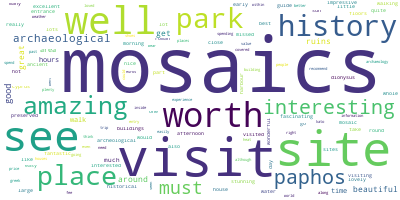

In [241]:
wordcloud = WordCloud(background_color = 'white',
                          relative_scaling = 1.0
                          ).generate_from_frequencies(frequency_dict)

wordcloud.to_image()

In [49]:
def generate_wordcloud_from_freq(frequency_dict): # optionally add: stopwords=STOPWORDS and change the arg below
    """A function to create a wordcloud according to the text frequencies as well as the text itself"""
    wordcloud = WordCloud(background_color = 'white',
                          relative_scaling = 1.0,
                          stopwords = {'to', 'of'} # set or space-separated string
                          ).generate_from_frequencies(frequency_dict)

    return wordcloud

In [242]:
def generate_wordcloud(freq_dict,id2word,corpus):
    freq_dict = []
    [freq_dict.extend(i) for i in corpus[:]]

    
    frequency_dict = dict()
    for i,j in freq_dict:
        key = id2word[i]
        if key in frequency_dict:
            frequency_dict[key] += j
        else:
            frequency_dict[key] = j
            
    return generate_wordcloud_from_freq(frequency_dict)

In [243]:
wc = generate_wordcloud(freq_dict,id2word,corpus)

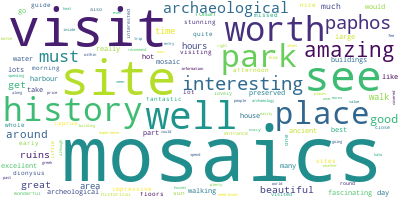

In [244]:
wc.to_image()